# **Q1**

In [ ]:
!pip install control
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 37.3 MB/s eta 0:00:00


Performance Metrics for Ziegler-Nichols:
Steady-State Error: 11.03
Overshoot (%): 1102.77
Settling Time (s): Not Available
Rise Time (s): 0.60
Peak Time (s): 10.00
----------------------------------------
Performance Metrics for Fuzzy Logic Control:
Steady-State Error: 0.23
Overshoot (%): 35.28
Settling Time (s): Not Available
Rise Time (s): 1.54
Peak Time (s): 6.44
----------------------------------------
Performance Metrics for Automatic Tuning:
Steady-State Error: 0.36
Overshoot (%): -27.15
Settling Time (s): Not Available
Rise Time (s): Not Available
Peak Time (s): 8.41
----------------------------------------


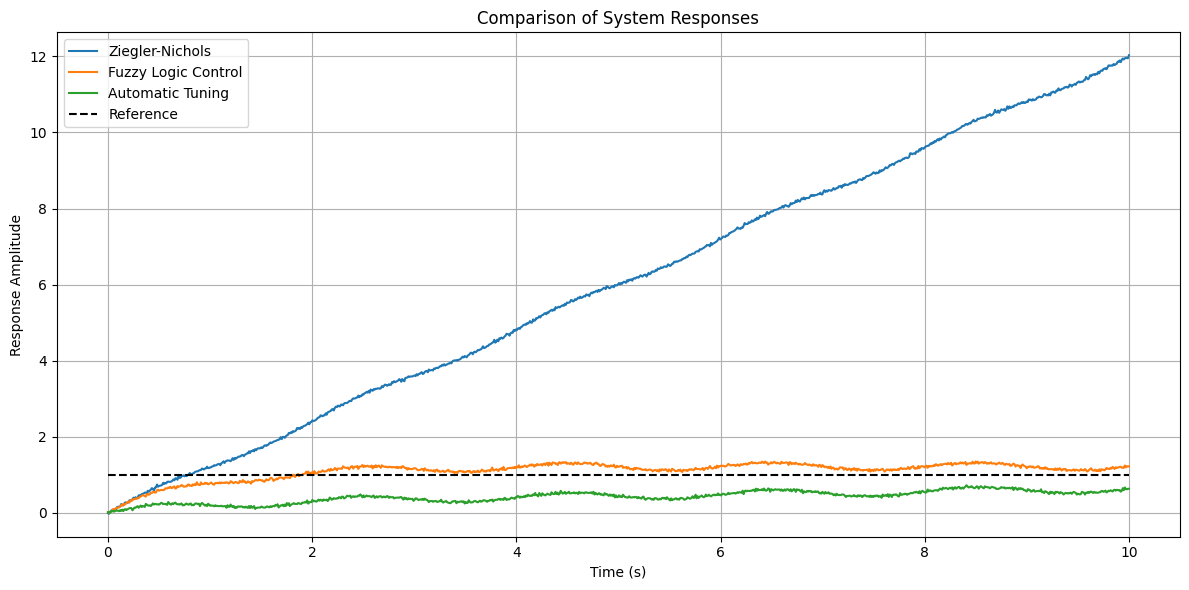

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import control
import skfuzzy as fuzz
from skfuzzy import control as fuzzy_ctrl
import matplotlib.pyplot as plt

class PIDController:
    def __init__(self):
        self.numerator_coeffs = [1, 0]
        self.denominator_coeffs = [1, 1]
        self.time_delay = 0.1
        self.noise_level = 0.02
        self.disturbance_strength = 0.1

    def create_system(self):
        num_delay, den_delay = control.pade(self.time_delay, n=1)
        delayed_system = control.TransferFunction(num_delay, den_delay)
        main_system = control.TransferFunction(self.numerator_coeffs, self.denominator_coeffs)
        return control.series(delayed_system, main_system)

    def ziegler_nichols_tuning(self):
        Ku = 2.0  # Ultimate gain
        Tu = 2.0  # Ultimate period
        Kp = 0.6 * Ku
        Ti = Tu / 2
        Td = Tu / 8
        Ki = Kp / Ti
        Kd = Kp * Td
        return Kp, Ki, Kd

    def automatic_tuning(self):
        settling_time_target = 4.0
        Kp = 1.2 / settling_time_target
        Ki = 0.5 * Kp / settling_time_target
        Kd = 0.5 * Kp * settling_time_target
        return Kp, Ki, Kd

    def fuzzy_control(self, error_signal, error_dot):
        # Define fuzzy variables for error and change in error
        error = fuzzy_ctrl.Antecedent(np.linspace(-2, 2, 5), 'error')
        error_dot_ctrl = fuzzy_ctrl.Antecedent(np.linspace(-2, 2, 5), 'error_dot')
        output_signal = fuzzy_ctrl.Consequent(np.linspace(-2, 2, 5), 'output')

        # Membership functions for error
        error['negative'] = fuzz.trimf(error.universe, [-2, -2, 0])
        error['zero'] = fuzz.trimf(error.universe, [-1, 0, 1])
        error['positive'] = fuzz.trimf(error.universe, [0, 2, 2])

        # Membership functions for change in error
        error_dot_ctrl['negative'] = fuzz.trimf(error_dot_ctrl.universe, [-2, -2, 0])
        error_dot_ctrl['zero'] = fuzz.trimf(error_dot_ctrl.universe, [-1, 0, 1])
        error_dot_ctrl['positive'] = fuzz.trimf(error_dot_ctrl.universe, [0, 2, 2])

        # Membership functions for output signal
        output_signal['negative'] = fuzz.trimf(output_signal.universe, [-2, -2, 0])
        output_signal['zero'] = fuzz.trimf(output_signal.universe, [-1, 0, 1])
        output_signal['positive'] = fuzz.trimf(output_signal.universe, [0, 2, 2])

        # Define rules for fuzzy logic controller
        rules = [
            fuzzy_ctrl.Rule(error['negative'] & error_dot_ctrl['negative'], output_signal['negative']),
            fuzzy_ctrl.Rule(error['zero'] & error_dot_ctrl['zero'], output_signal['zero']),
            fuzzy_ctrl.Rule(error['positive'] & error_dot_ctrl['positive'], output_signal['positive']),
            fuzzy_ctrl.Rule(error['negative'] & error_dot_ctrl['zero'], output_signal['negative']),
            fuzzy_ctrl.Rule(error['positive'] & error_dot_ctrl['zero'], output_signal['positive'])
        ]

        fuzzy_system = fuzzy_ctrl.ControlSystem(rules)
        simulation = fuzzy_ctrl.ControlSystemSimulation(fuzzy_system)

        simulation.input['error'] = np.clip(error_signal[-1], -2, 2)
        simulation.input['error_dot'] = np.clip(error_dot[-1], -2, 2)

        simulation.compute()

        return simulation.output['output']

    def simulate_control_system(self, controller_type='ZN', num_points=1000):
        time_vector = np.linspace(0, 10, num_points)
        delta_time = time_vector[1] - time_vector[0]

        reference_signal = np.ones_like(time_vector)

        # Initialize error signal array for all controller types
        error_signal = np.zeros_like(time_vector)

        if controller_type == 'ZN':
            Kp, Ki, Kd = self.ziegler_nichols_tuning()

            # Initialize variables for PID control
            integral_term = 0
            previous_error_value = 0

            system_response_output = np.zeros_like(time_vector)
            control_signal_output = np.zeros_like(time_vector)

            for i in range(len(time_vector)):
                error_signal[i] = reference_signal[i] - system_response_output[i]
                integral_term += error_signal[i] * delta_time
                derivative_term = (error_signal[i] - previous_error_value) / delta_time if i > 0 else 0

                control_signal_output[i] = Kp * error_signal[i] + Ki * integral_term + Kd * derivative_term

                if i > 0:
                    system_response_output[i] += system_response_output[i-1] + (control_signal_output[i-1] - system_response_output[i-1]) * delta_time

                previous_error_value = error_signal[i]

            # Add noise and disturbances to the response
            noise_component = self.noise_level * np.random.randn(len(time_vector))
            disturbance_component = self.disturbance_strength * np.sin(2 * np.pi * 0.5 * time_vector)
            system_response_output += noise_component + disturbance_component

            return time_vector, system_response_output

            # Similar PID control logic can go here (omitted for brevity)
####################3
        elif controller_type == 'auto':
            Kp, Ki, Kd = self.automatic_tuning()

            # Initialize variables for PID control
            integral_term = 0
            previous_error_value = 0
            system_response_output = np.zeros_like(time_vector)
            control_signal_output = np.zeros_like(time_vector)

            for i in range(len(time_vector)):
              error_signal[i] = reference_signal[i] - system_response_output[i]
              integral_term += error_signal[i] * delta_time
              derivative_term = (error_signal[i] - previous_error_value) / delta_time if i > 0 else 0

              control_signal_output[i] = Kp * error_signal[i] + Ki * integral_term + Kd * derivative_term

              if i > 0:
                system_response_output[i] += system_response_output[i-1] + (control_signal_output[i-1] - system_response_output[i-1]) * delta_time

              previous_error_value = error_signal[i]

    # Add noise and disturbances to the response
            noise_component = self.noise_level * np.random.randn(len(time_vector))
            disturbance_component = self.disturbance_strength * np.sin(2 * np.pi * 0.5 * time_vector)
            system_response_output += noise_component + disturbance_component

            return time_vector, system_response_output

######################
            return time_vector

        elif controller_type == 'fuzzy':
            system_response_output = np.zeros_like(time_vector)
            control_signal_output = np.zeros_like(time_vector)

            previous_error_value_fuzzy = reference_signal[0] - system_response_output[0]

            for i in range(len(time_vector)):
                current_error_value_fuzzy = reference_signal[i] - system_response_output[i]
                current_error_dot_value_fuzzy = current_error_value_fuzzy - previous_error_value_fuzzy

                control_signal_output[i] = self.fuzzy_control([current_error_value_fuzzy], [current_error_dot_value_fuzzy])

                if i > 0:
                    system_response_output[i] += system_response_output[i-1] + (control_signal_output[i-1] - system_response_output[i-1]) * delta_time

                previous_error_value_fuzzy = current_error_value_fuzzy

            noise_component_fuzzy = self.noise_level * np.random.randn(len(time_vector))
            disturbance_component_fuzzy = self.disturbance_strength * np.sin(2 * np.pi * 0.5 * time_vector)
            system_response_output += noise_component_fuzzy + disturbance_component_fuzzy

            return time_vector, system_response_output

    def assess_performance(self,time_data,response_data):
         reference_data=np.ones_like(time_data)
         steady_state_error_value=abs(reference_data[-1]-response_data[-1])
         max_response_value=max(response_data)
         overshoot_value=((max_response_value-reference_data[-1])/reference_data[-1])*100 if reference_data[-1]!=0 else 0

         # Adjusted settling time calculation to avoid IndexError.
         settling_time_value=None
         for i in range(len(response_data)-1,-1,-1):
             if not(reference_data[-1]*0.95<=response_data[i]<=reference_data[-1]*1.05):
                 settling_time_value=time_data[i+1] if i+1 < len(time_data) else None
                 break

         rise_time_value,start_time_value=None,None

         for i in range(len(response_data)):
             if response_data[i]>=0.1*reference_data[-1] and start_time_value is None:
                 start_time_value=time_data[i]
             if response_data[i]>=0.9*reference_data[-1]:
                 rise_time_value=time_data[i]-start_time_value if start_time_value is not None else None
                 break

         peak_time_value=time_data[np.argmax(response_data)]

         return {
             'Steady-State Error': steady_state_error_value,
             'Overshoot (%)': overshoot_value,
             'Settling Time (s)': settling_time_value,
             'Rise Time (s)': rise_time_value,
             'Peak Time (s)': peak_time_value
         }

# Instantiate the PID Controller class.
pid_controller_instance=PIDController()

# Simulate various controllers and evaluate their performance metrics.
simulation_results_dict={
    'Ziegler-Nichols':pid_controller_instance.simulate_control_system('ZN'),
    'Fuzzy Logic Control':pid_controller_instance.simulate_control_system('fuzzy'),
    'Automatic Tuning':pid_controller_instance.simulate_control_system('auto')
}

# Evaluate and print performance metrics for each controller method.
for method_name, result in simulation_results_dict.items():
    if isinstance(result, tuple) and len(result) == 2:
        time_vals, response_vals = result
        performance_metrics_result = pid_controller_instance.assess_performance(time_vals, response_vals)
        print(f"Performance Metrics for {method_name}:")
        for metric_name, metric_value in performance_metrics_result.items():
            if metric_value is not None:  # Check if the value is not None
                print(f"{metric_name}: {metric_value:.2f}")
            else:
                print(f"{metric_name}: Not Available")  # Handle None case
        print("-" * 40)
    else:
        print(f"Warning: {method_name} does not have valid results.")


# Plotting the results for visual comparison of controller outputs.
# Create a single figure
plt.figure(figsize=(12, 6))  # Set the size of the figure

# Set the title for the plot
plt.title('Comparison of System Responses')

# Response plot.
for method_name_plotting, (time_vals_plotting, response_vals_plotting) in simulation_results_dict.items():
    plt.plot(time_vals_plotting, response_vals_plotting, label=method_name_plotting)

# Plot the reference line
plt.plot(time_vals_plotting, np.ones_like(time_vals_plotting), '--', label='Reference', color='black')

plt.grid(True)
plt.legend()
plt.ylabel('Response Amplitude')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Control signal plot (if needed).
#axes[1].set_title('Control Signal Outputs')
#Add code here to plot control signals if necessary.

# Error signal plot (if needed).
#axes[2].set_title('Error Signal Analysis')
#Add code here to plot errors if necessary.

plt.tight_layout()
plt.show()

# **Q2**

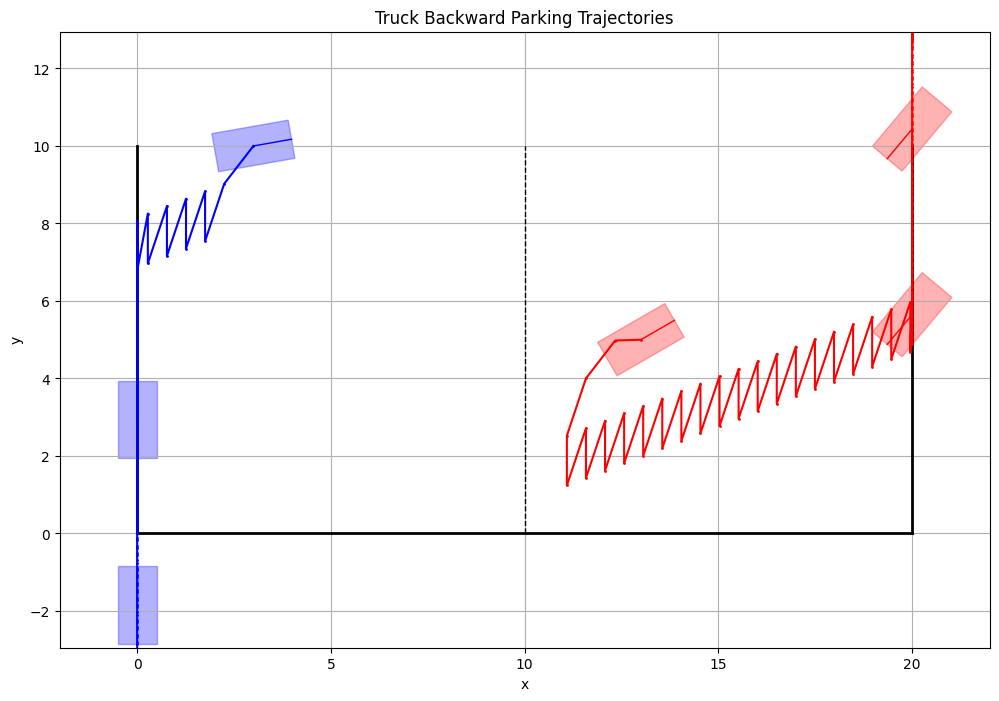

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, radians, degrees, asin, pi

class TruckController:
    def __init__(self):
        self.length = 2.0
        self.width = 1.0
        self.backward_speed = -1.0  # Negative for backward motion

    def get_steering_angle(self, x, phi):
        # Normalize phi to the range [-90°, 270°]
        phi = np.mod(phi + 90, 360) - 90

        # Calculate errors
        x_error = 10 - x
        phi_error = 90 - phi

        # Different control strategies based on position
        if abs(x - 10) > 1:  # Far from target x
            if x < 10:  # Need to move right
                if phi < 90:
                    return -40  # Sharp right turn
                else:
                    return 40  # Sharp left turn
            else:  # Need to move left
                if phi < 90:
                    return 40  # Sharp left turn
                else:
                    return -40  # Sharp right turn
        else:  # Close to target x, focus on orientation
            return np.clip(phi_error / 2, -40, 40)

    def update_state(self, x, y, phi, theta):
        # Convert angles to radians
        phi_rad = radians(phi)
        theta_rad = radians(theta)

        # Update state with backward motion (negative speed)
        x_new = x + self.backward_speed * (cos(phi_rad + theta_rad) + sin(theta_rad)*sin(phi_rad))
        y_new = y + self.backward_speed * (cos(phi_rad + theta_rad) - sin(theta_rad)*sin(phi_rad))
        phi_new = phi - degrees(asin(2*sin(theta_rad)/2))

        # Ensure phi stays within [-90°, 270°]
        phi_new = np.mod(phi_new + 90, 360) - 90

        # Ensure x stays within [0, 20]
        x_new = np.clip(x_new, 0, 20)

        return x_new, y_new, phi_new

def draw_truck(ax, x, y, phi, length=2, width=1, color='b'):
    phi_rad = radians(phi)

    # Calculate corner points of the truck rectangle
    corners = np.array([
        [-length/2, -width/2],
        [length/2, -width/2],
        [length/2, width/2],
        [-length/2, width/2]
    ])

    # Rotation matrix
    R = np.array([
        [cos(phi_rad), -sin(phi_rad)],
        [sin(phi_rad), cos(phi_rad)]
    ])

    # Rotate and translate corners
    corners = corners @ R.T + np.array([x, y])

    # Draw the truck body
    truck = plt.Polygon(corners, fill=True, alpha=0.3, color=color)
    ax.add_patch(truck)

    # Draw direction indicator (front of truck)
    front_center = np.array([length/2, 0]) @ R.T + np.array([x, y])
    ax.plot([x, front_center[0]], [y, front_center[1]], color=color, linewidth=1)

def simulate_parking(controller, x0, y0, phi0, max_steps=200):
    x, y = x0, y0
    phi = phi0
    trajectory = [(x, y, phi)]

    for _ in range(max_steps):
        # Get control input
        theta = controller.get_steering_angle(x, phi)

        # Update state
        x, y, phi = controller.update_state(x, y, phi, theta)
        trajectory.append((x, y, phi))

        # Check if target is reached (approximately)
        if abs(x - 10) < 0.3 and abs(phi - 90) < 5:
            break

    return np.array(trajectory)

# Create figure and axis
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Draw parking space
plt.plot([0, 20], [0, 0], 'k-', linewidth=2)
plt.plot([0, 0], [0, 10], 'k-', linewidth=2)
plt.plot([20, 20], [0, 10], 'k-', linewidth=2)
plt.plot([10, 10], [0, 10], 'k--', linewidth=1)

# Create controller and simulate from different starting positions
controller = TruckController()
initial_positions = [
    (3, 10, 10),
    (13, 5, 30)
]

colors = ['b', 'r']
for (x0, y0, phi0), color in zip(initial_positions, colors):
    # Simulate trajectory
    trajectory = simulate_parking(controller, x0, y0, phi0)

    # Plot trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], color + '.-', markersize=2)

    # Draw truck at key positions
    draw_truck(ax, x0, y0, phi0, color=color)  # Start
    draw_truck(ax, *trajectory[-1], color=color)  # End

    # Draw intermediate positions
    for i in range(len(trajectory)//4, len(trajectory), len(trajectory)//4):
        draw_truck(ax, *trajectory[i], color=color)

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('Truck Backward Parking Trajectories')
plt.xlim(-2, 22)
plt.ylim(-2, 12)

plt.show()

# **Q4**

Training fuzzy system...
Testing fuzzy system...
Plotting results...


<ipython-input-2-9c6e590b302b>:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.z[l] = math.exp(exponent)
<ipython-input-2-9c6e590b302b>:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.g_bar[q + 1, l] = self.g_bar[q, l] - self.alpha*(self.f_hat[q] - self.g_u[q])*self.z[l]/b
<ipython-input-2-9c6e590b302b>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.x_bar[q + 1, l] = self.x_bar[q, l] - self.alpha*((self.f_hat[q] - self.g_u[q])/b)*(self.g_bar[q

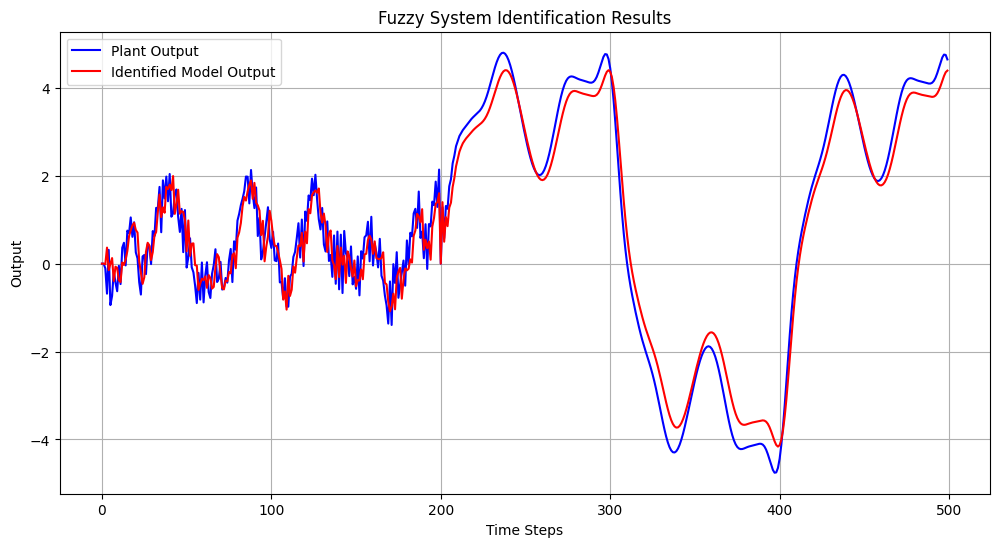

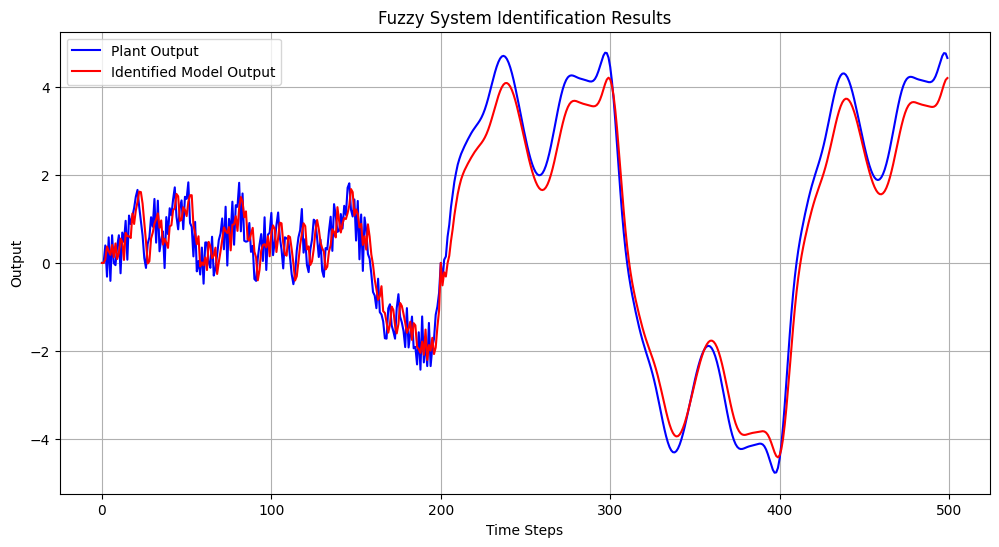

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import math

class FuzzyIdentificationSystem:
    def __init__(self, M=5, alpha=0.1, epochs=200, total_num=500, u_min=-1, u_max=1):
        self.M = M
        self.alpha = alpha
        self.epochs = epochs
        self.total_num = total_num
        self.u_min = u_min
        self.u_max = u_max

        # Initialize arrays
        self.x_bar = np.zeros((epochs, M))
        self.g_bar = np.zeros((epochs, M))
        self.sigma = np.zeros((epochs, M))
        self.y = np.zeros((total_num, 1))
        self.x = np.zeros((total_num, 1))
        self.y_hat = np.zeros((total_num, 1))
        self.f_hat = np.zeros((total_num, 1))
        self.z = np.zeros((total_num, 1))
        self.g_u = np.zeros((total_num, 1))

        # Store final parameters
        self.x_bar_final = None
        self.g_bar_final = None
        self.sigma_final = None

    def nonlinear_function(self, x):
        """Calculate the nonlinear function g(u)"""
        return 0.6*np.sin(pi*x) + 0.3*np.sin(3*pi*x) + 0.1*np.sin(5*pi*x)

    def initialize_parameters(self):
        """Initialize the system parameters"""
        h = (self.u_max - self.u_min)/(self.M - 1)

        # Initialize first input
        self.x[0] = -1 + (2*np.random.randn(1, 1))
        self.y[0] = 0
        self.g_u[0] = self.nonlinear_function(self.x[0])
        self.f_hat[0] = self.g_u[0]

        # Initialize x_bar and g_bar
        for k in range(self.M):
            self.x_bar[0, k] = -1 + h*(k - 1)
            self.g_bar[0, k] = self.nonlinear_function(self.x_bar[0, k])

        # Calculate sigma
        maxi = np.max(self.x_bar[0, :])
        mini = np.min(self.x_bar[0, :])
        self.sigma[0, :] = (maxi - mini)/self.M

        # Copy initial values to second row
        self.x_bar[1, :] = self.x_bar[0, :]
        self.g_bar[1, :] = self.g_bar[0, :]
        self.sigma[1, :] = self.sigma[0, :]

    def calculate_fuzzy_output(self, x_input, q, training=True):
        """Calculate fuzzy system output"""
        a = 0
        b = 0

        # Use appropriate parameters based on training/testing phase
        x_bar_use = self.x_bar[q, :] if training else self.x_bar_final
        g_bar_use = self.g_bar[q, :] if training else self.g_bar_final
        sigma_use = self.sigma[q, :] if training else self.sigma_final

        for l in range(self.M):
            exponent = -((x_input - x_bar_use[l])**2) / (sigma_use[l]**2)
            exponent = np.clip(exponent, -100, 100)
            self.z[l] = math.exp(exponent)
            b += self.z[l]
            a += g_bar_use[l]*self.z[l]

        return a/b if b != 0 else 0, b

    def train(self):
        """Train the fuzzy identification system"""
        self.initialize_parameters()

        for q in range(1, self.epochs - 1):
            # Generate input and calculate actual output
            self.x[q] = -1 + (2*np.random.randn(1, 1))
            self.g_u[q] = self.nonlinear_function(self.x[q])

            # Calculate fuzzy system output
            self.f_hat[q], b = self.calculate_fuzzy_output(self.x[q], q)

            # Calculate system outputs
            self.y[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.g_u[q]
            self.y_hat[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.f_hat[q]

            # Update parameters
            for l in range(self.M):
                self.g_bar[q + 1, l] = self.g_bar[q, l] - self.alpha*(self.f_hat[q] - self.g_u[q])*self.z[l]/b
                self.x_bar[q + 1, l] = self.x_bar[q, l] - self.alpha*((self.f_hat[q] - self.g_u[q])/b)*(self.g_bar[q, l] - self.f_hat[q])*self.z[l]*2*(self.x[q] - self.x_bar[q, l])/(self.sigma[q, l]**2)
                self.sigma[q + 1, l] = self.sigma[q, l] - self.alpha*((self.f_hat[q] - self.g_u[q])/b)*(self.g_bar[q, l] - self.f_hat[q])*self.z[l]*2*((self.x[q] - self.x_bar[q, l])**2)/(self.sigma[q, l]**3)

        # Store final parameters
        self.x_bar_final = self.x_bar[self.epochs-1, :]
        self.g_bar_final = self.g_bar[self.epochs-1, :]
        self.sigma_final = self.sigma[self.epochs-1, :]

    def test(self):
        """Test the trained system"""
        for q in range(self.epochs, self.total_num - 1):
            # Generate test input
            self.x[q] = np.sin(2*q*pi/200)
            self.g_u[q] = self.nonlinear_function(self.x[q])

            # Calculate fuzzy system output
            self.f_hat[q], _ = self.calculate_fuzzy_output(self.x[q], q, training=False)

            # Calculate system outputs
            self.y[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.g_u[q]
            self.y_hat[q + 1] = 0.3*self.y[q] + 0.6*self.y[q - 1] + self.f_hat[q]

    def plot_results(self):
        """Plot the results"""
        plt.figure(figsize=(12, 6))
        plt.plot(self.y, label='Plant Output', color='blue')
        plt.plot(self.y_hat, label='Identified Model Output', color='red')
        plt.title('Fuzzy System Identification Results')
        plt.xlabel('Time Steps')
        plt.ylabel('Output')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
def main():
    # Create and train the fuzzy system
    fuzzy_system = FuzzyIdentificationSystem()
    print("Training fuzzy system...")
    fuzzy_system.train()

    print("Testing fuzzy system...")
    fuzzy_system.test()

    print("Plotting results...")
    fuzzy_system.plot_results()

if __name__ == "__main__":
    main()

# Create and run the fuzzy identification system
fuzzy_system = FuzzyIdentificationSystem()
fuzzy_system.train()
fuzzy_system.test()
fuzzy_system.plot_results()

# **Q5**

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1q5eMhBeYyUHfEjI8DhkqqrjNTbPUUuJ5

Downloading...
From: https://drive.google.com/uc?id=1q5eMhBeYyUHfEjI8DhkqqrjNTbPUUuJ5
To: /content/AirQualityUCI.xlsx
100% 1.30M/1.30M [00:00<00:00, 16.1MB/s]


Loading and preprocessing data...
Preparing data splits...
Training RBF model...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training ANFIS model...

Evaluating models...

Plotting validation set results...


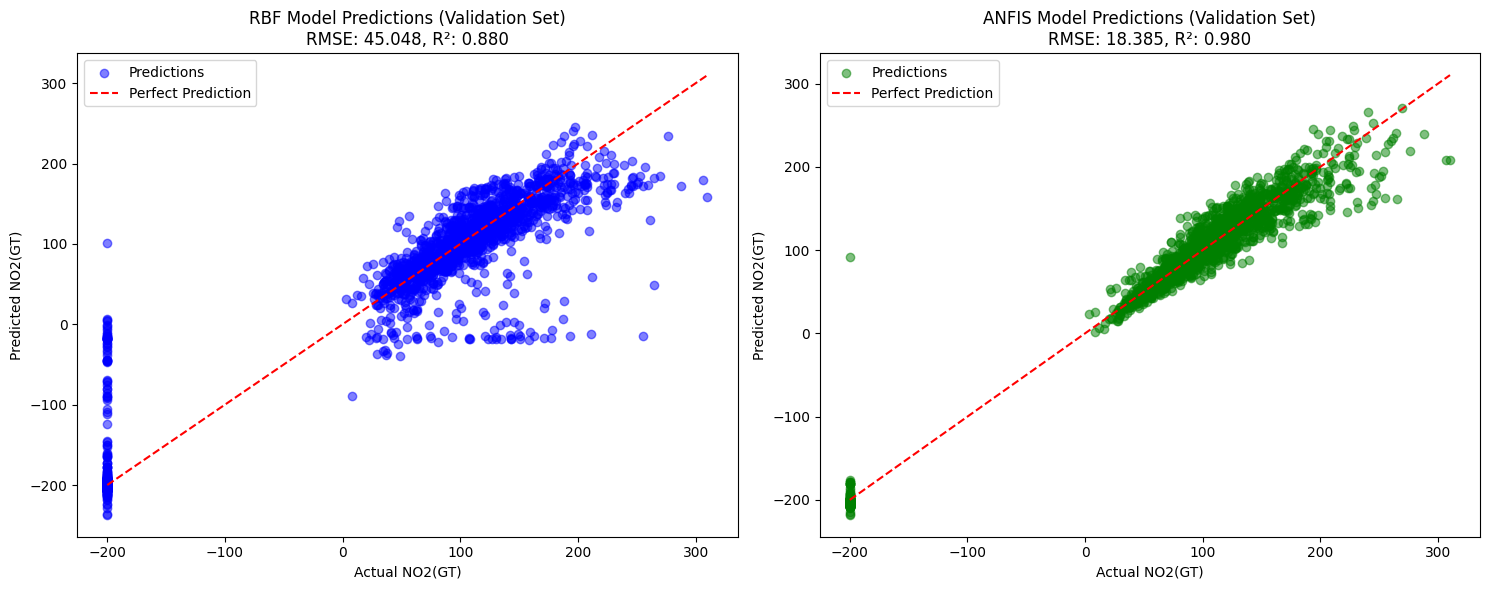


Plotting test set results...


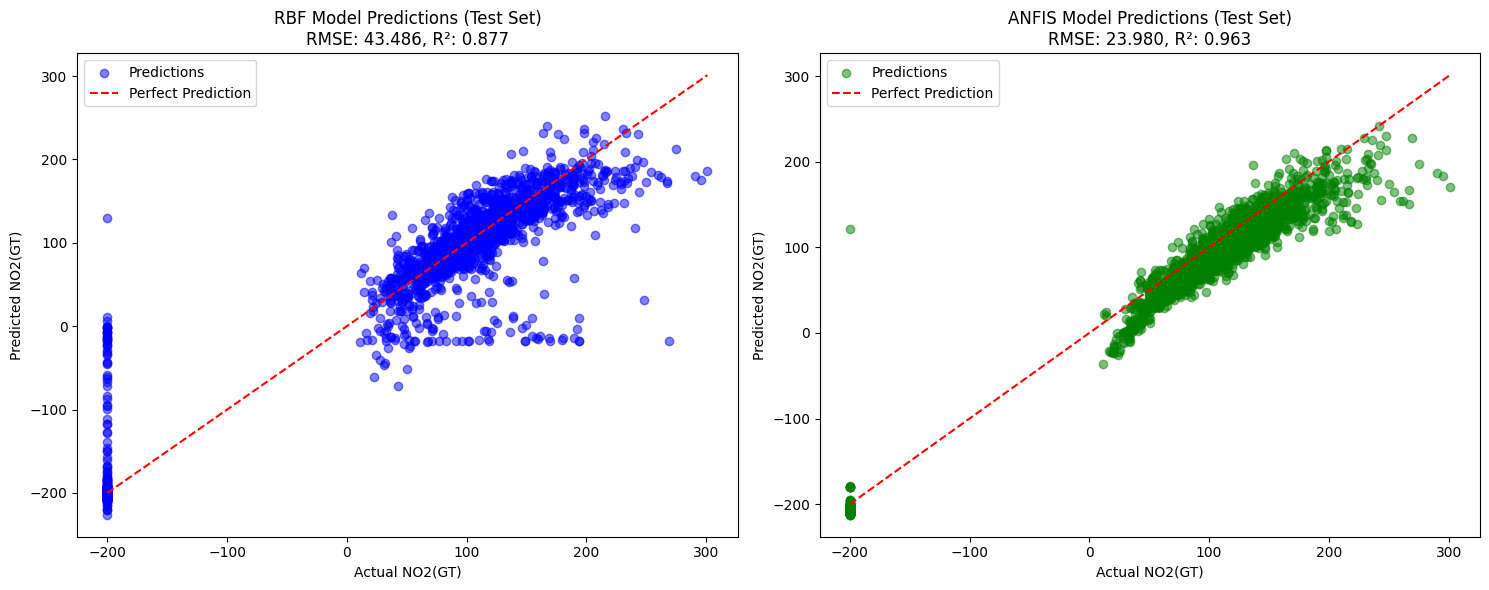


Validation Set Results:
RBF - RMSE: 45.048, R²: 0.880
ANFIS - RMSE: 18.385, R²: 0.980

Test Set Results:
RBF - RMSE: 43.486, R²: 0.877
ANFIS - RMSE: 23.980, R²: 0.963


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
def load_and_preprocess_data(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Convert Date and Time columns to datetime
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

    # Drop original Date and Time columns
    df = df.drop(['Date', 'Time'], axis=1)

    # Handle missing values using forward fill
    df = df.ffill()

    return df

# Custom RBF Network implementation
class RBFNetwork:
    def __init__(self, n_centers=50):
        self.n_centers = n_centers
        self.kmeans = KMeans(n_clusters=n_centers)
        self.mlp = MLPRegressor(
            hidden_layer_sizes=(n_centers,),
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=42
        )

    def rbf_features(self, X):
        # Calculate distances to centers and apply RBF transformation
        distances = np.zeros((X.shape[0], self.n_centers))
        for i, center in enumerate(self.centers):
            distances[:, i] = np.linalg.norm(X - center, axis=1)

        # Apply Gaussian RBF
        sigma = np.mean(distances) / np.sqrt(2 * self.n_centers)
        return np.exp(-(distances ** 2) / (2 * sigma ** 2))

    def fit(self, X, y):
        # Find RBF centers using K-means
        self.kmeans.fit(X)
        self.centers = self.kmeans.cluster_centers_

        # Transform data using RBF features
        X_rbf = self.rbf_features(X)

        # Train the neural network
        self.mlp.fit(X_rbf, y)

    def predict(self, X):
        X_rbf = self.rbf_features(X)
        return self.mlp.predict(X_rbf)

# Custom ANFIS-like implementation
class CustomANFIS:
    def __init__(self, n_input_mfs=3, learning_rate=0.01):
        self.n_input_mfs = n_input_mfs
        self.learning_rate = learning_rate
        self.model = MLPRegressor(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            solver='adam',
            learning_rate_init=learning_rate,
            max_iter=1000,
            random_state=42
        )

    def generate_membership_degrees(self, X):
        centers = np.linspace(X.min(), X.max(), self.n_input_mfs)
        sigma = (centers[1] - centers[0]) / 2

        memberships = np.zeros((X.shape[0], self.n_input_mfs))
        for i, center in enumerate(centers):
            memberships[:, i] = np.exp(-(X - center)**2 / (2 * sigma**2))

        return memberships

    def fit(self, X, y):
        X_memberships = np.hstack([self.generate_membership_degrees(X[:, i])
                                 for i in range(X.shape[1])])
        self.model.fit(X_memberships, y)

    def predict(self, X):
        X_memberships = np.hstack([self.generate_membership_degrees(X[:, i])
                                 for i in range(X.shape[1])])
        return self.model.predict(X_memberships)

# Split data into features and target
def prepare_data(df, target_col='NO2(GT)'):
    X = df.drop(['DateTime', target_col], axis=1)
    y = df[target_col]

    # Split data into train, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

# Evaluate models
def evaluate_model(model, X, y_true, model_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        'Model': model_name,
        'RMSE': rmse,
        'R2': r2,
        'Predictions': y_pred
    }

# Visualize results
def plot_results(y_true, rbf_results, anfis_results, set_name):
    plt.figure(figsize=(15, 6))

    # RBF plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, rbf_results['Predictions'], alpha=0.5, c='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual NO2(GT)')
    plt.ylabel('Predicted NO2(GT)')
    plt.title(f'RBF Model Predictions ({set_name})\nRMSE: {rbf_results["RMSE"]:.3f}, R²: {rbf_results["R2"]:.3f}')
    plt.legend()

    # ANFIS plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, anfis_results['Predictions'], alpha=0.5, c='green', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual NO2(GT)')
    plt.ylabel('Predicted NO2(GT)')
    plt.title(f'ANFIS Model Predictions ({set_name})\nRMSE: {anfis_results["RMSE"]:.3f}, R²: {anfis_results["R2"]:.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
def main():
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data('/content/AirQualityUCI.xlsx')

    print("Preparing data splits...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df)

    print("Training RBF model...")
    rbf_model = RBFNetwork(n_centers=50)
    rbf_model.fit(X_train, y_train)

    print("Training ANFIS model...")
    anfis_model = CustomANFIS()
    anfis_model.fit(X_train, y_train)

    print("\nEvaluating models...")
    # Evaluate models on validation set
    rbf_val_results = evaluate_model(rbf_model, X_val, y_val, 'RBF')
    anfis_val_results = evaluate_model(anfis_model, X_val, y_val, 'ANFIS')

    # Evaluate models on test set
    rbf_test_results = evaluate_model(rbf_model, X_test, y_test, 'RBF')
    anfis_test_results = evaluate_model(anfis_model, X_test, y_test, 'ANFIS')

    # Plot results
    print("\nPlotting validation set results...")
    plot_results(y_val, rbf_val_results, anfis_val_results, 'Validation Set')
    print("\nPlotting test set results...")
    plot_results(y_test, rbf_test_results, anfis_test_results, 'Test Set')

    # Print performance metrics
    print("\nValidation Set Results:")
    print(f"RBF - RMSE: {rbf_val_results['RMSE']:.3f}, R²: {rbf_val_results['R2']:.3f}")
    print(f"ANFIS - RMSE: {anfis_val_results['RMSE']:.3f}, R²: {anfis_val_results['R2']:.3f}")

    print("\nTest Set Results:")
    print(f"RBF - RMSE: {rbf_test_results['RMSE']:.3f}, R²: {rbf_test_results['R2']:.3f}")
    print(f"ANFIS - RMSE: {anfis_test_results['RMSE']:.3f}, R²: {anfis_test_results['R2']:.3f}")

if __name__ == "__main__":
    main()